# Equivariant Neural Rendering

In [1]:
import random, os, sys
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
%matplotlib inline
import imageio
import torch
import torchvision
from torchvision.transforms import ToTensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sys.path.insert(1, os.path.join(sys.path[0], '../src/'))

sys.path.append('/content/equiv-neural-rendering/')
from enr.models.neural_renderer import *

""" Detect local path """
local_path = !pwd
local_path = local_path[0]


## 1. Introduction


The paper from Dupont et al. introduces an approach to render 2D images into implicit, equivariant 3D representations. The authors argue that the scene representations need not be explicit, as long as the transformations to it occur in an equivariant manner. Their model is trained on a dataset of rotation symmetries, learning to produce novel views from a single image of a scene.

Current approaches in scene representations present difficulties with scalability. Voxel grids, point clouds and other traditional methods have high computational and memory requirements. Reconstrucion from incomplete or noisy data is also a challenging task with these methods, often requiring 3D information during training. Generating novel views of a scene given some input views presents the same difficulties. Finally, traditional neural networks are not equivariant with respect to general transformation groups. 3D equivariance especially requires specifc techniques like steerable filters. The authors attempt to solve these problems by proposing a new method which results in more scalable, implicit representations that are also equivariant with respect to transformations. 

The difference between an explicit scene representation (mesh grid) and an implicit one can be seen in the figure below:

<p align="center">
  <img src="../src/imgs/paper_screenshots/fig2.png" width="500" />
</p>



  
### 1.1: Methodology

The proposed model uses a series of convolutions to map scene representations to images. Specifically, the scene representation is passed through 3D convolutions, followed by 1x1 convolutions and a set of 2D convolutions that maps them to image space. The reverse renderer is the transpose of this operation. Equivariance is enforced by applying transformations in both the scene and image spaces. Because the representation space is a deep voxel grid, the transformations in this space are defined by a 3D rotation matrix. Inverse warping with trilinear interpolation is also used in the model, to reconstruct the values after rotations.

<p align="center">
  <img src="../src/imgs/paper_screenshots/fig5.png" width="500" />
</p>

For training, two images of the same scene are passed through the renderer. Then, the 3D transformation grid is applied in the representation space to turn one into the other, before passing them to the inverse renderer. Finally, the output images are compared to the original inputs to obtain the loss values. Training in this manner ensures the model learns equivariant representations, as the loss evaluates both the actual rendering and the accuracy of the matching transformations from both spaces.

<p align="center">
  <img src="../src/imgs/paper_screenshots/fig4.png" width="500" />
</p>

Finally, the authors claim that the rendering loss used makes little change in results. They provide l1 norm, l2 norm and SSIM loss as candidates, and conduct ablation studies to determine the tradeoffs between them.

### 1.2: Datasets
The authors evaluate their model on 4 datasets, including two ShapeNet benchmarks as well as two novel datasets of the authors design. They use an image size of 128 x 128 and a representation size of 64 x 32 x 32 x 32.
The datasets are presented in table 1. 


| *Dataset*  | *Source*  |  *Sample* | *# Scenes*  |*# images per scene*| *# datapoints*|
|---|---|---|---|---|--|
| Chairs  | [ShapeNet](https://icml20-prod.cdn-apple.com/eqn-data/data/chairs.zip)  | ![Chair](../src/imgs/paper_screenshots/chair.png)  |  6591 | 50  | 329 550|
| Cars  |  [ShapeNet](https://icml20-prod.cdn-apple.com/eqn-data/data/cars.zip) | ![Car](../src/imgs/paper_screenshots/car.png)  |  3514 |  50 | 175 700|
| MugsHQ  |  [Apple](https://icml20-prod.cdn-apple.com/eqn-data/data/mugs.zip) | ![Mug](../src/imgs/paper_screenshots/mug.png)  |  214 | 150  | 32 100|
| 3D mountainset  |  [Apple](https://icml20-prod.cdn-apple.com/eqn-data/data/mountains.zip) | ![Mountain](../src/imgs/paper_screenshots/mountain.png) |  559 |  50 | 27 950|

Table 1.: *Overview of datasets considered for equivariant neural rendering by Dupont et al.*

### 1.3: Experiments of paper

The proposed model is compared against three baseline models, each one making assumptions much stronger than the original study.

|   | TCO  |  DGQN | SRN  | Proposed model  |
|---|---|---|---|---|
| Requires Absolute Pose  | Yes  | Yes | Yes | No |
| Requires Pose at Inference Time  | No  | Yes | Yes | No |
| Optimization at Inference Time  | No  | No | Yes | No |

The qualitative comparisons against the baseline models in single shot novel view synthesis with the ShapeNet chairs dataset reveals that the model achieves similar to SoTA results while making far fewer assumptions than the other methods. It can produce high quality novel views by achieving the desired equivariant transformation in representation space.

<p align="center">
  <img src="../src/imgs/paper_screenshots/results.png" width="500" />
</p>

Results similar to the chairs were reported in the other datasets, with some variations due to the specific challenges of each one. For example, the mountains contain extremely complex geometric information, which severly limits the detail of the novel view synthesis.



<p align="center">
  <img src="../src/imgs/paper_screenshots/chairs.png" width="500" />
  <img src="../src/imgs/paper_screenshots/cars.png" width="500" />
  <img src="../src/imgs/paper_screenshots/mugs.png" width="500" />
  <img src="../src/imgs/paper_screenshots/mountains.png" width="500" />
</p>

Finally, the authors performed ablation studies to test novel view synthesis when using different loss functions. The results in each one were similar and no inherent prefered approach was suggested. In the end, they reason that choice of loss function is task specific.


### 1.4 Demo

The subsequent section presents a demonstration of the experiments conducted in the original paper.

**Loading and plotting the original image**

The model infers from a single image and renders a second image from a novel view.

/tmp/ipykernel_24484/206027007.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread( path)


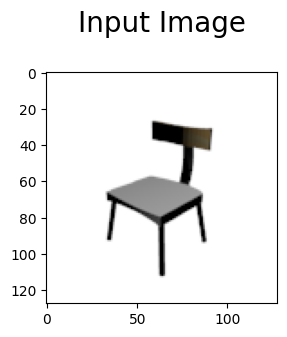

In [2]:
def plot_img_tensor(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    plt.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))


# ---------------------------------------------------------
# Loading and plotting the original image
# ---------------------------------------------------------
    
    
# Load trained chairs modellocal_path
path = local_path + '/trained-models/chairs.pt'
model = load_model(path).to(device)

# You can also try loading other examples (e.g. 'chair1.png')
path  = local_path + '/imgs/example-data/chair4.png'
img = imageio.imread( path)
# Visualize image
plt.figure(figsize = (3, 3))
plt.title('Input Image\n', size = 20)
plt.imshow(img)

**Rendering the scene reprensentation without rotation and translation**

The model demonstrate good capabilities of rendering the inferred representation of the model in the abscense of any transformations.

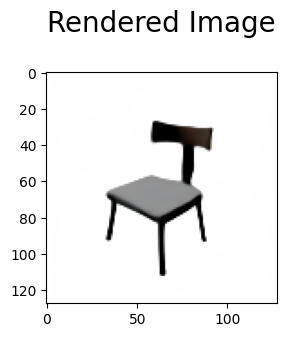

In [3]:
# Convert image to tensor and add batch dimension
img_source = ToTensor()(img)
img_source = img_source.unsqueeze(0).to(device)

# Infer scene representation
scene = model.inverse_render(img_source)

# We can render the scene representation without rotating it
rendered = model.render(scene)

plt.figure(figsize = (3, 3))
plt.title('Rendered Image\n', size = 20)
plot_img_tensor(rendered.detach())

org = rendered.detach().clone()

**Rotating and translating the scene reprensentation and rendering a novel view**

When applying a roto-translation one can observe that the models performance decreases. 

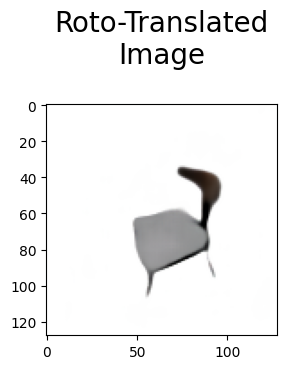

In [4]:
# As a rotation matrix can feel a little abstract, we can also reason in terms of 
# camera azimuth and elevation. The initial coordinate at which the source image
# is observed is given by the following azimuth and elevation. Note that these
# are not necessary to generate novel views (as shown above), we just use them 
# for convenience to generate rotation matrices
azimuth_source = torch.Tensor([0.]).to(device)
elevation_source = torch.Tensor([0.]).to(device)
translations_source = torch.Tensor([0., 0., 0.]).to(device)

# You can set these to any value you like!
# Positive (negative) values correspond to moving camera to the right (left)
azimuth_shift = torch.Tensor([30.]).to(device)  
# Positive (negative) values correspond to moving camera up (down)
elevation_shift = torch.Tensor([30.]).to(device)
# Translation values
translations_shift = torch.Tensor([.2, -.2, 0.]).to(device)

azimuth_target = azimuth_source + azimuth_shift
elevation_target = elevation_source + elevation_shift
translations_target = translations_source + translations_shift

# Rotate scene to match target camera angle
rotated_scene = model.rotate_source_to_target(
    scene, 
    azimuth_source, elevation_source, translations_source,
    azimuth_target, elevation_target, translations_target
)

# Render rotated scene
rendered = model.render(rotated_scene)

plt.figure(figsize = (3, 3))
plt.title('Roto-Translated\nImage\n', size = 20)
plot_img_tensor(rendered.detach())

## 2. Response 

Much of the success of Deep Learning can be attributed to effective representation learning. Such representations do not need to be humanly interpretable, but can also be abstract. The original authors proposed an implicit 3D representation of the scene, instead of an explicit 3D representation such as mesh-grids or point clouds. By removing the need for an explicit 3D representation, they developed a model that requires no 3D supervision. It only requires 2D images with the corresponding rotation angle of the camera, that was used between these images. Their model can generate a novel view from a single image. The qualitative results of their model’s performance motivated us to extent their research.

In the original paper the authors used 3D rotations to generate novel views, meaning that they rotate a camera on a sphere around the scene. 3D rotations do not act transitively on 3D space. Therefore, we proposed to extend their model to roto-translations, with the intermediate proof-of-concept step of using translations only. The objective was to obtain a model that can generate a novel view for any camera position in 3D space, within a reasonable range of movement.

## 3. Novel Contribution

In this section we describe the novel contributions of our research.

- We introduce a method to generate training data for the equivariant neural rendering models (section 3.1).

- We show that the original model, which was solely pretrained on rotations, can already generate plausible translations along the axes running parallel to the image plane (i.e. orthogonal to the line of sight) through inductive bias (section 3.2).

- We introduce a model that has been trained on translations and a model that has been trained on roto-translations (section 3.3). This part constitutes the main contribution of our research.







### 3.1 Datasets

The authors present datasets consisting of rotational transformations. However, they do not provide instructions or tools for further data generation. To address this limitation we developed a new pipeline using blender for producing images of 3D-models under rotations, translations and roto-translations. Our pipeline can be used to increase the size of the training data, or to extend training data to new transformation groups.

The following section demonstrates the practical application of our pipeline for data production, by demonstrating how to use blender to generate new training data containing roto-translations.

#### 3.1.1  Demonstration: populating datasets for the ISO(3)-group using Blender 
Similar to Dupont et al., we perform experiments on the [ShapeNet Core](https://shapenet.org/download/shapenetcore)-Chairs benchmark. It is worth noting that the objects included in the ShapeNetCore dataset are already normalized and consistently aligned. However, the subsequent pipeline can be adapted to accommodate any 3D-object data that is processable by Blender. Here follows a brief demonstration of how data can be constructed using Blender 3.5.1.


In [5]:
""" Detect local path """
local_path = !pwd
local_path = local_path[0]

**Run the subsequent cells once to install Blender with wget**

_NB! Installation assumes Linux-based OS._




In [6]:
""" Install / Load wget """
%pip install wget
import wget

""" Install blender """
# Download blender 3.5.1
!wget https://ftp.nluug.nl/pub/graphics/blender/release/Blender3.5/blender-3.5.1-linux-x64.tar.xz

# Unpack 
!tar -xvf blender-3.5.1-linux-x64.tar.xz
!rm {local_path}/blender-3.5.1-linux-x64.tar.xz

# Move and rename for shorter commands
!mv {local_path}/blender-3.5.1-linux-x64 {local_path}/data_prep/demo/blender


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
--2023-05-14 15:07:13--  https://ftp.nluug.nl/pub/graphics/blender/release/Blender3.5/blender-3.5.1-linux-x64.tar.xz
Resolving ftp.nluug.nl (ftp.nluug.nl)... 2001:67c:6ec:221:145:220:21:40, 145.220.21.40
Connecting to ftp.nluug.nl (ftp.nluug.nl)|2001:67c:6ec:221:145:220:21:40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261628416 (250M) [application/x-tar]
Saving to: ‘blender-3.5.1-linux-x64.tar.xz’

blender-3.5.1-linux 100%[===================>] 249,51M  6,22MB/s    in 38s     

2023-05-14 15:07:52 (6,49 MB/s) - ‘blender-3.5.1-linux-x64.tar.xz’ saved [261628416/261628416]

blender-3.5.1-linux-x64/
blender-3.5.1-linux-x64/license/
blender-3.5.1-linux-x64/license/THIRD-PARTY-LICENSES.txt
blender-3.5.1-linux-x64/license/jemalloc.txt
blender-3.5.1-linux-x64/license/bmonofont-i18n.ttf.txt
blender-3.5.1-linux-x64/license

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/_lsprof.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/_datetime.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/_hashlib.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/_queue.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/_md5.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/resource.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/_heapq.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/_pickle.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/_csv.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/lib-dynload/_bz2.cpython-310-x86_64-

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/gzip.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/struct.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/datetime.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/io.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/keyword.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/profile.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/fnmatch.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/calendar.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/heapq.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/sched.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/fractions.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/fileinput.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/tabnanny.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/functools.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/uuid.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/antigravity.py
blender-3.5.1-linux-x64/3.5

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/zstandard/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/zstandard/py.typed
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/zstandard/__init__.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/zstandard/backend_cffi.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/zstandard/backend_c.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/zstandard/__init__.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/requests-2.27.1-py3.10.egg-info/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/requests-2.27.1-py3.10.egg-info/top_level.txt
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/requests-2.27.1-py3.10.egg-info/SOURCES.txt
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/requests-2.27.1-py3.10.egg-info/dependency_links.txt
blender-3.5.1-linux-x64/3.5/pyt

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/diagnose.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/live_render.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/style.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/default_styles.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/repr.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/abc.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/_ratio.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/_inspect.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/status.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich/theme.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pip/_vendor/rich

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/linalg/_umath_linalg.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/linalg/__init__.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/linalg/linalg.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/_typing/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/_typing/_add_docstring.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/_typing/_nested_sequence.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/_typing/_scalars.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/_typing/_array_like.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/_typing/setup.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/_typing/_char_codes.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/_multiarray_tests.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/defchararray.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/fromnumeric.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/_string_helpers.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/_add_newdocs_scalars.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/_dtype_ctypes.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/_dtype.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/umath.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core/einsumfunc.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/core

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/__init__.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/testutils.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/mrecords.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/core.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/setup.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/mrecords.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/bench.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/core.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/extras.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/__init__.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/ma/extras.py
blender

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/type_check.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/_version.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/scimath.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/shape_base.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/npyio.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/arrayterator.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/polynomial.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/__init__.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/npyio.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/stride_tricks.pyi
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/numpy/lib/recfunctions.py
blender-3.5.1-linux-x64/3.5/python/lib

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Compiler/PyrexTypes.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Compiler/TypeSlots.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Compiler/Pipeline.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Compiler/Visitor.pxd
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Compiler/ExprNodes.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Compiler/Scanning.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Compiler/StringEncoding.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Compiler/Version.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Compiler/ModuleNode.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/TestUtils.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/Cython/Tempit

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/MaterialX/PyMaterialXCore.cpython-310-x86_64-linux-gnu.so.1
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/MaterialX/PyMaterialXGenMdl.cpython-310-x86_64-linux-gnu.so.1
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/MaterialX/PyMaterialXCore.cpython-310-x86_64-linux-gnu.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/MaterialX/colorspace.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/MaterialX/PyMaterialXGenShader.cpython-310-x86_64-linux-gnu.so.1.38.6
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/MaterialX/main.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/MaterialX/PyMaterialXGenOsl.cpython-310-x86_64-linux-gnu.so.1
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/toml-0.10.2-py3.10.egg-info/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/toml-0.10.2-py3.10.egg-info/top_level.txt

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/Ndr/__init__.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/GeomUtil/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/GeomUtil/_geomUtil.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/GeomUtil/__init__.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/UsdUI/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/UsdUI/__init__.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/UsdUI/_usdUI.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/SdrGlslfx/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/SdrGlslfx/__init__.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/Glf/
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/Glf/_glf.so
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/site-packages/pxr/Glf/__init__.py
blender-

blender-3.5.1-linux-x64/3.5/python/lib/python3.10/config-3.10-x86_64-linux-gnu/config.c
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/config-3.10-x86_64-linux-gnu/makesetup
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/filecmp.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/pickletools.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/sndhdr.py
blender-3.5.1-linux-x64/3.5/python/lib/python3.10/cProfile.py
blender-3.5.1-linux-x64/3.5/python/lib/libpython3.10.a
blender-3.5.1-linux-x64/3.5/scripts/
blender-3.5.1-linux-x64/3.5/scripts/freestyle/
blender-3.5.1-linux-x64/3.5/scripts/freestyle/styles/
blender-3.5.1-linux-x64/3.5/scripts/freestyle/styles/polygonalize.py
blender-3.5.1-linux-x64/3.5/scripts/freestyle/styles/sketchy_topology_preserved.py
blender-3.5.1-linux-x64/3.5/scripts/freestyle/styles/sketchy_multiple_parameterization.py
blender-3.5.1-linux-x64/3.5/scripts/freestyle/styles/nature.py
blender-3.5.1-linux-x64/3.5/scripts/freestyle/styles/qi0_not_external_contour

blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/properties_physics_dynamicpaint.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/properties_data_lightprobe.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/space_properties.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/space_outliner.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/properties_data_pointcloud.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/properties_data_empty.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/space_view3d_toolbar.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/space_spreadsheet.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/space_statusbar.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/generic_ui_list.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/space_node.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/properties_mask_common.py
blender-3.5.1-linux-x64/3.5/scripts/startup/bl_ui/properties_data_armature.py
blender-3.5.1-linux-x64/3.5/scripts/start

blender-3.5.1-linux-x64/3.5/scripts/addons/animation_animall/
blender-3.5.1-linux-x64/3.5/scripts/addons/animation_animall/translations.py
blender-3.5.1-linux-x64/3.5/scripts/addons/animation_animall/__init__.py
blender-3.5.1-linux-x64/3.5/scripts/addons/render_copy_settings/
blender-3.5.1-linux-x64/3.5/scripts/addons/render_copy_settings/operator.py
blender-3.5.1-linux-x64/3.5/scripts/addons/render_copy_settings/translations.py
blender-3.5.1-linux-x64/3.5/scripts/addons/render_copy_settings/__init__.py
blender-3.5.1-linux-x64/3.5/scripts/addons/render_copy_settings/presets.py
blender-3.5.1-linux-x64/3.5/scripts/addons/render_copy_settings/panel.py
blender-3.5.1-linux-x64/3.5/scripts/addons/render_copy_settings/data.py
blender-3.5.1-linux-x64/3.5/scripts/addons/object_collection_manager/
blender-3.5.1-linux-x64/3.5/scripts/addons/object_collection_manager/internals.py
blender-3.5.1-linux-x64/3.5/scripts/addons/object_collection_manager/operator_utils.py
blender-3.5.1-linux-x64/3.5/scri

blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/gpu/parallel_active_index.h
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/gpu/parallel_sorted_index.h
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/gpu/image.h
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/hip/
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/hip/globals.h
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/hip/compat.h
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/hip/kernel.cpp
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/hip/config.h
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/metal/
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/metal/context_begin.h
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/source/kernel/device/metal/function_constants.h
blender-3.5.1-linux-x64/3.5/scripts

blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_gfx1012.fatbin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_compute_75.ptx
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_gfx1010.fatbin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_gfx1031.fatbin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_sm_52.cubin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_optix_shader_raytrace.ptx
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_sm_35.cubin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_gfx1011.fatbin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_gfx1100.fatbin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_gfx900.fatbin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_gfx1034.fatbin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_gfx902.fatbin
blender-3.5.1-linux-x64/3.5/scripts/addons/cycles/lib/kernel_optix_osl_services.ptx
b

blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/model_meta_topology.py
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/scripting_gui.py
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/chess2.pov
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/patio-radio.pov
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/bsp_Tango.pov
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/cornell.pov
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/gamma_showcase.pov
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/grenadine.pov
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/subsurface.pov
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/float5.pov
blender-3.5.1-linux-x64/3.5/scripts/addons/render_povray/templates_pov/biscuit.pov
blender-3.5

blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansHebrew-Regular.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoEmoji-VariableFont_wght.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansEthiopic-Regular.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansSymbols2-Regular.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansGeorgian-VariableFont_wdth,wght.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansTamil-VariableFont_wdth,wght.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansGujarati-Regular.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansJavanese-Regular.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/lastresort.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/DejaVuSansMono.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansThai-VariableFont_wdth,wght.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansMyanmar-Regular.woff2
blender-3.5.1-linux-x64/3.5/datafiles/fonts/NotoSansKannada-VariableFont_wdth,wght.wof

blender-3.5.1-linux-x64/3.5/datafiles/studiolights/matcap/resin.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/matcap/ceramic_lightbulb.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/matcap/clay_brown.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/matcap/basic_side.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/matcap/toon.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/matcap/basic_dark.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/matcap/check_rim_dark.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/matcap/basic_2.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/matcap/metal_lead.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/world/
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/world/courtyard.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/world/sunrise.exr
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/world/license.txt
blender-3.5.1-linux-x64/3.5/datafiles/studiolights/world/forest.exr
blender-3.5

blender-3.5.1-linux-x64/3.5/datafiles/locale/eu/
blender-3.5.1-linux-x64/3.5/datafiles/locale/eu/LC_MESSAGES/
blender-3.5.1-linux-x64/3.5/datafiles/locale/eu/LC_MESSAGES/blender.mo
blender-3.5.1-linux-x64/3.5/datafiles/locale/nl/
blender-3.5.1-linux-x64/3.5/datafiles/locale/nl/LC_MESSAGES/
blender-3.5.1-linux-x64/3.5/datafiles/locale/nl/LC_MESSAGES/blender.mo
blender-3.5.1-linux-x64/3.5/datafiles/locale/hr/
blender-3.5.1-linux-x64/3.5/datafiles/locale/hr/LC_MESSAGES/
blender-3.5.1-linux-x64/3.5/datafiles/locale/hr/LC_MESSAGES/blender.mo
blender-3.5.1-linux-x64/3.5/datafiles/locale/ko/
blender-3.5.1-linux-x64/3.5/datafiles/locale/ko/LC_MESSAGES/
blender-3.5.1-linux-x64/3.5/datafiles/locale/ko/LC_MESSAGES/blender.mo
blender-3.5.1-linux-x64/3.5/datafiles/locale/ab/
blender-3.5.1-linux-x64/3.5/datafiles/locale/ab/LC_MESSAGES/
blender-3.5.1-linux-x64/3.5/datafiles/locale/ab/LC_MESSAGES/blender.mo
blender-3.5.1-linux-x64/3.5/datafiles/locale/fi/
blender-3.5.1-linux-x64/3.5/datafiles/locale/f

blender-3.5.1-linux-x64/lib/libsycl.so.6
blender-3.5.1-linux-x64/lib/libOpenImageIO.so.2.4
blender-3.5.1-linux-x64/lib/libboost_program_options.so
blender-3.5.1-linux-x64/lib/libOpenEXR.so.30
blender-3.5.1-linux-x64/lib/libOpenEXRUtil.so.30
blender-3.5.1-linux-x64/lib/libMaterialXGenOsl.so
blender-3.5.1-linux-x64/lib/libIex.so
blender-3.5.1-linux-x64/lib/libboost_wave.so.1.80.0
blender-3.5.1-linux-x64/lib/libboost_chrono.so
blender-3.5.1-linux-x64/lib/libOpenImageIO_Util.so.2.4.6
blender-3.5.1-linux-x64/lib/libosdGPU.so
blender-3.5.1-linux-x64/lib/libopenvdb.so.10.0.0
blender-3.5.1-linux-x64/lib/libboost_wserialization.so.1.80.0
blender-3.5.1-linux-x64/lib/libIlmThread.so.30.5.1
blender-3.5.1-linux-x64/lib/libboost_wave.so
blender-3.5.1-linux-x64/lib/libOpenImageIO.so
blender-3.5.1-linux-x64/lib/libboost_system.so.1.80.0
blender-3.5.1-linux-x64/lib/libIlmThread.so
blender-3.5.1-linux-x64/lib/mesa/
blender-3.5.1-linux-x64/lib/mesa/libGL.so.1
blender-3.5.1-linux-x64/lib/mesa/libGLU.so.1


_Run render demo_

In order to build a roto-translational dataset pass both command line arguments: _--rotation --translation_ . To build a dataset composed only of rotations or translations pass only the singular argument respectively.

In [7]:
""" Run Demo"""
!{local_path}/data_prep/demo/blender/blender -b --python data_prep/demo/render_blender.py -- --scene_name data --rotation --translation --scene_folder /data_prep/demo/data/model_1 --local_path {local_path}

Blender 3.5.1 (hash e1ccd9d4a1d3 built 2023-04-24 23:31:15)
(  0.0000 sec |   0.0000 sec) Importing OBJ '/home/olineranum/Documents/DL2/equiv-neural-rendering/data_prep/demo/data/model_1/models/model_normalized.obj'...
  (  0.0001 sec |   0.0000 sec) Parsing OBJ file...
    (  0.0023 sec |   0.0023 sec) Done, loading materials and images...
    (  0.0041 sec |   0.0040 sec) Done, building geometries (verts:103 faces:441 materials: 4 smoothgroups:0) ...
    (  0.0069 sec |   0.0068 sec) Done.
  (  0.0069 sec |   0.0069 sec) Finished importing: '/home/olineranum/Documents/DL2/equiv-neural-rendering/data_prep/demo/data/model_1/models/model_normalized.obj'
Progress: 100.00%

Info: Removed 0 vertice(s)
../src/intel/isl/isl.c:2220: FINISHME: ../src/intel/isl/isl.c:isl_surf_supports_ccs: CCS for 3D textures is disabled, but a workaround is available.
Fra:1 Mem:16.12M (Peak 17.21M) | Time:00:00.08 | Syncing Light
Fra:1 Mem:16.12M (Peak 17.21M) | Time:00:00.08 | Syncing Camera
Fra:1 Mem:16.12M 

Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.07 | Rendering 26 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.08 | Rendering 51 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.09 | Rendering 64 / 64 samples
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.09 | Compositing
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.09 | Compositing | Determining resolution
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.09 | Compositing | Initializing execution
Fra:1 Mem:16.06M (Peak 16.73M) | Time:00:00.09 | Compositing | Tile 1-1
Fra:1 Mem:16.00M (Peak 16.73M) | Time:00:00.09 | Compositing | De-initializing execution
Saved: '/home/olineranum/Documents/DL2/equiv-neural-rendering/data_prep/demo/output/rot_trans_dataset/data/00006.png'
 Time: 00:00.09 (Saving: 00:00.00)

Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Light
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Camera
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Empty
Fra:1 Mem:16.69M (Peak 16.69M) | Time

Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.06 | Rendering 26 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.08 | Rendering 51 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.08 | Rendering 64 / 64 samples
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.08 | Compositing
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.08 | Compositing | Determining resolution
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.08 | Compositing | Initializing execution
Fra:1 Mem:16.06M (Peak 16.73M) | Time:00:00.09 | Compositing | Tile 1-1
Fra:1 Mem:16.00M (Peak 16.73M) | Time:00:00.09 | Compositing | De-initializing execution
Saved: '/home/olineranum/Documents/DL2/equiv-neural-rendering/data_prep/demo/output/rot_trans_dataset/data/00013.png'
 Time: 00:00.09 (Saving: 00:00.00)

Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Light
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Camera
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Empty
Fra:1 Mem:16.69M (Peak 16.69M) | Time

Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.07 | Rendering 26 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.09 | Rendering 51 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.10 | Rendering 64 / 64 samples
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.10 | Compositing
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.10 | Compositing | Determining resolution
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.10 | Compositing | Initializing execution
Fra:1 Mem:16.06M (Peak 16.73M) | Time:00:00.10 | Compositing | Tile 1-1
Fra:1 Mem:16.00M (Peak 16.73M) | Time:00:00.10 | Compositing | De-initializing execution
Saved: '/home/olineranum/Documents/DL2/equiv-neural-rendering/data_prep/demo/output/rot_trans_dataset/data/00020.png'
 Time: 00:00.10 (Saving: 00:00.00)

Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Light
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Camera
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Empty
Fra:1 Mem:16.69M (Peak 16.69M) | Time

Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.06 | Rendering 26 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.06 | Rendering 51 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.07 | Rendering 64 / 64 samples
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.07 | Compositing
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.07 | Compositing | Determining resolution
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.07 | Compositing | Initializing execution
Fra:1 Mem:16.06M (Peak 16.73M) | Time:00:00.07 | Compositing | Tile 1-1
Fra:1 Mem:16.00M (Peak 16.73M) | Time:00:00.07 | Compositing | De-initializing execution
Saved: '/home/olineranum/Documents/DL2/equiv-neural-rendering/data_prep/demo/output/rot_trans_dataset/data/00027.png'
 Time: 00:00.07 (Saving: 00:00.00)

Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Light
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Camera
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Empty
Fra:1 Mem:16.69M (Peak 16.69M) | Time

Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.05 | Rendering 26 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.06 | Rendering 51 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.06 | Rendering 64 / 64 samples
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.06 | Compositing
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.06 | Compositing | Determining resolution
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.06 | Compositing | Initializing execution
Fra:1 Mem:16.06M (Peak 16.73M) | Time:00:00.06 | Compositing | Tile 1-1
Fra:1 Mem:16.00M (Peak 16.73M) | Time:00:00.06 | Compositing | De-initializing execution
Saved: '/home/olineranum/Documents/DL2/equiv-neural-rendering/data_prep/demo/output/rot_trans_dataset/data/00034.png'
 Time: 00:00.06 (Saving: 00:00.00)

Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Light
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Camera
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Empty
Fra:1 Mem:16.69M (Peak 16.69M) | Time

Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.05 | Rendering 26 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.05 | Rendering 51 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.06 | Rendering 64 / 64 samples
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.06 | Compositing
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.06 | Compositing | Determining resolution
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.06 | Compositing | Initializing execution
Fra:1 Mem:16.06M (Peak 16.73M) | Time:00:00.06 | Compositing | Tile 1-1
Fra:1 Mem:16.00M (Peak 16.73M) | Time:00:00.06 | Compositing | De-initializing execution
Saved: '/home/olineranum/Documents/DL2/equiv-neural-rendering/data_prep/demo/output/rot_trans_dataset/data/00041.png'
 Time: 00:00.06 (Saving: 00:00.00)

Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Light
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Camera
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Empty
Fra:1 Mem:16.69M (Peak 16.69M) | Time

Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.05 | Rendering 26 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.06 | Rendering 51 / 64 samples
Fra:1 Mem:16.70M (Peak 16.73M) | Time:00:00.07 | Rendering 64 / 64 samples
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.07 | Compositing
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.07 | Compositing | Determining resolution
Fra:1 Mem:15.92M (Peak 16.73M) | Time:00:00.07 | Compositing | Initializing execution
Fra:1 Mem:16.06M (Peak 16.73M) | Time:00:00.07 | Compositing | Tile 1-1
Fra:1 Mem:16.00M (Peak 16.73M) | Time:00:00.07 | Compositing | De-initializing execution
Saved: '/home/olineranum/Documents/DL2/equiv-neural-rendering/data_prep/demo/output/rot_trans_dataset/data/00048.png'
 Time: 00:00.07 (Saving: 00:00.00)

Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Light
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Camera
Fra:1 Mem:16.69M (Peak 16.69M) | Time:00:00.00 | Syncing Empty
Fra:1 Mem:16.69M (Peak 16.69M) | Time

_Display demonstration of roto-translation dataset_

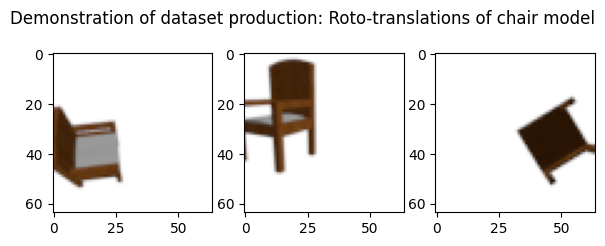

In [9]:
""" Display random sample outputs """
# Load 3 random images from output directory
path = local_path + "/data_prep/demo/output/rot_trans_dataset/data/"
random_file = [random.choice(os.listdir(path)) for img in range(3)]
images = [mpimg.imread(path + image) for image in random_file]

# Plot sampleset
fig, axs = plt.subplots(1, 3, figsize=(7, 3))
for ax, id in zip(axs, range(3)):
    ax.imshow(images[id])
plt.title('Demonstration of dataset production: Roto-translations of chair model\n', loc='right')
plt.show()

#### 3.1.2 Populating new datasets

We use the afformention pipeline to build 3 new datasets: 

   * _Rotations_: used to reproduce the results presented by Dupont et al.
   * _Translations_: used to train a model with higher capacity for translation invariance.
   * _Roto-translations_: used to train a roto-translational invariant model.
    
We downscale the datasets in order to reduce the computational costs of training the new models. For all three datasets we use the partitioning described in table 2. 


|   | **# Scenes**  |  **# Images per scene** | **Resolution**  | **# datapoints**  |
|---|---|---|---|---|
| Train  | 2306  |  50 | 64 x 64  |  115300 |
| Validataion  | 331  | 50  |  64 x 64 | 16550  |

Table 2: _Partition of new datasets_


| **Hyperparameter**  | **R**  |  **X** | **Y**  | **Z**  | **Resolution** |
|---|---|---|---|---|---|
|   | 1.5  | [-0.4, 0.4]  | [-0.3, 0.5]  | [-0.4, 0.4] | 64 x 64|

Table 3: _Hyperparameters used when populating the new dataset._

We construct the datasets by sampling poses from various views. In case of rotations the camera is placed on a sphere with a radius **R**. For each view, a value between 0 and $2\pi$ is uniformly sampled for the elevation and azimuth angle of the camera and rotated accordingly. In case of translations, for each view, a value is uniformly sampled from a range of **X**, **Y** and **Z** locations of the chair.

### 3.2 Translations through inductive bias

Through inductive bias, (reasonably small) translations, which are orthogonal to the line of sight, already work on the model that has only been trained on rotations. This is due to the fact that the model uses a CNN architecture, which is translationally equivariant along the image plane. Still, it seems interesting that the model does not seem to encode any information from the outside of the object to produce a good estimation.

*** More investigation necessary here (check if zero background is mapped to zero in 3D representation, check if translation introduces zero-padding in 3D presentation, check if zeros in 3D representation are mapped to zeros in image) ***

#### Translations only

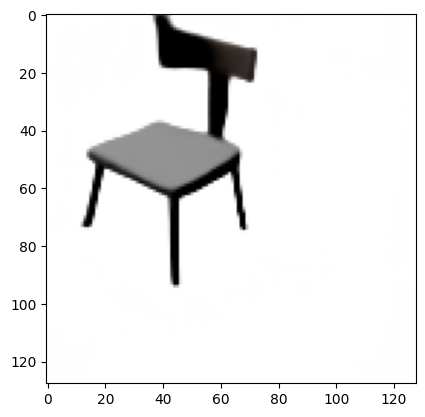

In [10]:
azimuth_shift = torch.Tensor([0.]).to(device)
elevation_shift = torch.Tensor([0.]).to(device)
translations_shift = torch.Tensor([0., 0.3, 0.3]).to(device)

azimuth_target = azimuth_source + azimuth_shift
elevation_target = elevation_source + elevation_shift
translations_target = translations_source + translations_shift

# Rotate scene to match target camera angle
rotated_scene = model.rotate_source_to_target(
    scene, 
    azimuth_source, elevation_source, translations_source,
    azimuth_target, elevation_target, translations_target
)

# Render rotated scene
rendered = model.render(rotated_scene)

plot_img_tensor(rendered.detach())

#### Roto-translations

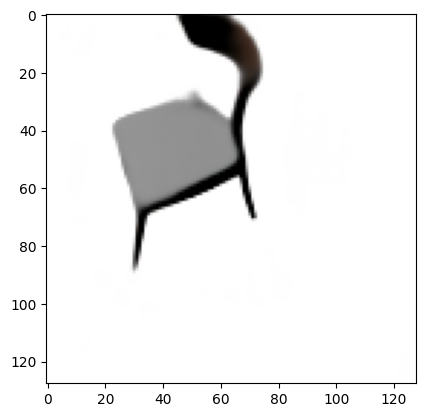

In [11]:
azimuth_shift = torch.Tensor([30.]).to(device)
elevation_shift = torch.Tensor([30.]).to(device)
translations_shift = torch.Tensor([0., 0.3, 0.3]).to(device)

azimuth_target = azimuth_source + azimuth_shift
elevation_target = elevation_source + elevation_shift
translations_target = translations_source + translations_shift

# Rotate scene to match target camera angle
rotated_scene = model.rotate_source_to_target(
    scene, 
    azimuth_source, elevation_source, translations_source,
    azimuth_target, elevation_target, translations_target
)

# Render rotated scene
rendered = model.render(rotated_scene)

plot_img_tensor(rendered.detach())




Nonetheless, translations along the line of sight do not work out-of-the-box and require explicit training. The reason for that is that the equivariant neural rendering model considers the depth dimension via incorporating its information into the channels of the CNN. More concrete, the model uses the following code:

```python
# Reshape 3D -> 2D
reshaped = inputs.view(batch_size, channels * depth, height, width)
```

Furthermore, due to the central positioning of the objects in the images, the model has problems rendering scenes that extent to the image boundaries. Therefore, we trained our model on translations first, before moving on to roto-translations

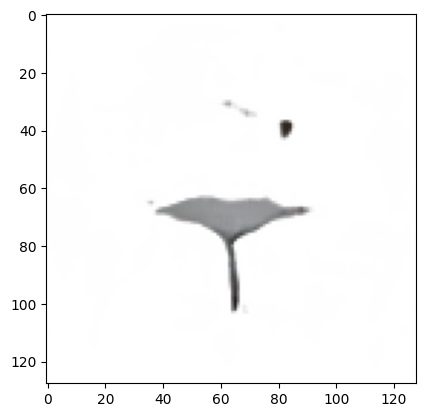

In [12]:
azimuth_shift = torch.Tensor([0.]).to(device)
elevation_shift = torch.Tensor([0.]).to(device)
translations_shift = torch.Tensor([0.5, 0., 0.]).to(device)

azimuth_target = azimuth_source + azimuth_shift
elevation_target = elevation_source + elevation_shift
translations_target = translations_source + translations_shift

# Rotate scene to match target camera angle
rotated_scene = model.rotate_source_to_target(
    scene, 
    azimuth_source, elevation_source, translations_source,
    azimuth_target, elevation_target, translations_target
)

# Render rotated scene
rendered = model.render(rotated_scene)

plot_img_tensor(rendered.detach())

### 3.3 Extending the model

#### 3.3.1 Translations

As shown in section 3.2, the original model, which was pretrained on rotation data only, can already produce valid shifts for short distances along the image plane but not along the line of sight. We produced a translation dataset for the model to learn how to deal with more extensive shifts of the camera, as well as learning how to deal with shifts of any size along the line of sight. Because the depth dimension is encoded within the channels of the convolution layers, it is plausible that the model can learn to make use of this information to produce a zoom-like effect, similar to which one would expect when moving the camera closer to the object.

Since we can only cover a finite range of translations, we limit the range of shift to -0.5 and 0.5 for all directions. This value was chosen because it still leaves the chair mostly in the image and hence, still contains useful information for training and inference.

*** Show the new model and present the results ***

*** Depending on how our experiments go, we might need to talk about model architecture and more inductive biases here ***

#### 3.3.2 Roto-Translations

The motivation for our research was to extend the equivariant neural rendering model to be able to produce novel views for any camera position in 3D space. Roto-translations fulfill this requirement. More specifically, we can cover all 3D positions by limiting the azimuth angle to a range of -180 to 180 degrees and the elevation angle to a range of -90 to 90 degrees. The latter avoids a flipping of the camera which causes problems with the compatibility of translations in Blender vs translations in the model. Nonetheless, by being able to rotate the camera along the azimuth, we can still cover all necessary views. For translations, we can obviously only cover a finite distances, therefore we chose the same range as in section 3.2 (-0.5 to 0.5 for all directions).

*** Show the new model and present the results ***

## 4. Conclusion

- Some preliminary results (working model)

## 5. Contributions 

Close the notebook with a description of the each students' contribution.